# Reporte 2020-2

El trabajo realizado durante este semestre se enfocó en la reescritura de diferentes partes del código que componen el modelo con la finalidad de facilitar su expanción cuando sea necesario expandir sus funciones. También se escribieron las funciones necesarias para guardar los resultados de las simulaciones como archivos csv.

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scripts.ltee_model import *
from datetime import datetime
from dataclasses import dataclass
from scipy.integrate import solve_ivp

import networkx as nx
try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError(" Import Error")

## Almacenamiento de resultados
En vez de tener arreglos dispersos donde se guardaban las soluciones de los sistemas de ecuaciones y otro para los parámetros, se creó una clase para almacenar la información producida por el modelo. De manera que en las simulaciones se tenga una lista de instancias que contienen el identificador, la densidad, los parametros y relación parental de cada cepa.
A partir de dicha lista, al final de cada ciclo se crean los archivos csv que contienen la información de cada cepa generada hasta ese momento, además de poder graficar a partir de dichos datos, se puede reconstruir la lista de instancias a partir de los archivos para extender las simulaciones. 

In [2]:
@dataclass
class Bacteria:
    '''A class that stores bacteria values'''
    id: int
    od: np.ndarray
    ps: list
    mother: int
    alive: bool

In [3]:
def get_ivp(t, exp_time, res, bac):
    ''' Create a 1D array of time, resource and densities to use them
        to solve a ODE System'''
    time = [exp_time[t], exp_time[t+1]]
    get_res = res[[-1], [-1]] 
    #get_bac = np.array([])
    get_bac = [b.od[1,-1] for b in bac] 
    y0 = np.append(get_res, get_bac)
    return time, y0#, get_ps

In [4]:
# This works for instances
def batch_fix(t, x, bac):
    #dS = x[0]
    N = len(bac)
    dx = np.empty(N+1)
    
    for i, p in enumerate(bac):
        m, a = p.ps
        #xi = x[i+1]
        #
        fSi = (m * x[0]) / (a + x[0])
        #dS = dS + (fSi * x[i])
        dx[0] -= dx[0] + (fSi * x[i+1]) # this should be x+1?
        dx[i+1] = x[i+1] * fSi
        
    #dx[0] = - dS
    return dx

In [5]:
# This is the previous version
def batch(t, x, bac):
    #dS = x[0] # Was working with this
    dS = 0
    N = len(bac)
    dx = np.empty(N+1)
    
    for i, p in enumerate(bac):
        m, a = p.ps
        #xi = x[i+1]
        #
        fSi = (m * x[0]) / (a + x[0])
        dS = dS + (fSi * x[i+1])
        #dx[0] -= dx[0] + (fSi * x[i+1]) # this should be x+1?
        dx[i+1] = x[i+1] * fSi    
    dx[0] = - dS
    return dx

In [6]:
def check_res(t,x,bac): return x[0]
check_res.terminal = True
check_res.direction = 0

In [7]:
def simulate(t, exp_time, res, bac):
    this_time, this_y0 = get_ivp(t, exp_time, res, bac)
    t_eval = np.linspace(this_time[0],this_time[1], 2)
    #sol = solve_ivp(batch, this_time, this_y0, args=[bacteria], dense_output=True, t_eval=t_eval, events=check_res)
    sol = solve_ivp(batch, this_time, this_y0, args=[bac], dense_output=True, t_eval=t_eval)
    return sol

In [8]:
def mutate(bac): #add p_mut, sigma to params
    rand_p = np.random.default_rng().uniform(0,1)
    p_mut = 5e-3 # was 5e-2 # 5e-3
    this_od = bac.od[1,-1]
    ismut = (rand_p < (p_mut * this_od))
    if ismut:
        sigma = 0.02
        # Parameters for new strain 
        m_mut = np.random.default_rng().normal(bac.ps[0], sigma, 1)
        a_mut = np.random.default_rng().normal(bac.ps[1], sigma, 1)
        ps_mut = np.append(m_mut,a_mut)
        # density
        od_len = len(bac.od[0])
        od_fill = np.zeros(od_len)
        new_od = np.vstack((bac.od[0], od_fill))
        new_od[1,-1] = 0.033 # Density of new strains
        # Create new strain here
        b_mut = Bacteria(len(bacteria)+1, new_od, ps_mut, bac.id, True)
    else:
        b_mut = None
    return b_mut

In [9]:
def alive_strains(bac):
    num_types = 0
    for i, b in enumerate(bac):
        if b.alive:
            num_types+=1
    return num_types

In [10]:
def life_and_death(bac):
    num_types = alive_strains(bac)
    for b in bac:
        if b.alive:
            if b.od[1,-1] < death: #works
            #if b.od[1,-1] <= death:
                print('Dead id: ', b.id, 'at ', ti)
                b.alive = False
                b.od[1,-1] = 0.0
            if b.alive and num_types<50:
                bac_mut = mutate(b)
                if bac_mut:
                    bac.append(bac_mut)
                    print('Born: ', bac_mut.id, 'from: ', b.id, 'at ', ti)
    return bac

In [11]:
# This should be a method
def update_res_od(sol_t, sol_y, bac):
    '''Update resource and optic densities from the ODE solution'''
    sol_res = np.stack((sol_t[1:],sol_y[0][1:]))
    new_res = np.append(res, sol_res, axis=1) # This works
    sol_od = np.delete(sol_y[1:],0,1)
    # Array with time in axis 0 and without the first elements 
    #     for each array of densities
    new_od = np.vstack((sol_t[1:], sol_od))
    for i, b in enumerate(bac):
        b.od = np.append(b.od, new_od[[0,i+1],:], axis=1)        
    return new_res, bac
    

In [12]:
def transfer(res,bac):
    for b in bac:
        b.od[1,-1] *= d
    res[1,-1] = 1.0
    return res, bac

In [13]:
def create_dfs(bac,res):
    len_bac = len(bac)
    len_od = len(bac[0].od[0])
    arr_ps = np.empty([len_bac, 4])
    result_array = np.empty([len_bac+1, len_od])
    result_array[0] = bac[0].od[0] # Time array
    col_name_bac = ['id', 'm', 'a', 'mother']
    for i, b in enumerate(bac):
        result_array[i+1] = b.od[1]
        arr_ps[i] = [b.id, b.ps[0], b.ps[1],b.mother]
    df_ods = pd.DataFrame(result_array.T)
    df_res = pd.DataFrame(res.T)
    df_ps = pd.DataFrame(arr_ps)
    df_ps.columns = col_name_bac
    return df_ods, df_res, df_ps

In [14]:
def cycle_df(bac, res, t0, t1, cycle_counter):
    '''Create dataframe and store it as cvs'''
    len_bac = len(bac)
    len_od = len(bac[0].od[0][t0:t1])
    arr_ps = np.empty([len_bac, 4])
    result_array = np.empty([len_bac+1, len_od])
    result_array[0] = bac[0].od[0][t0:t1] # Time array
    col_name_bac = ['id', 'm', 'a', 'mother']
    bac_names = [f'x_{i}' for i, b in enumerate(bac)]
    bac_names.insert(0,'t')
    res_cycle = res[:,t0:t1]
    #test_result_array = [b.od[1] for i, b in enumerate(bacteria)]
    for i, b in enumerate(bac): # Use comprehension list instead (?)
        result_array[i+1] = b.od[1][t0:t1]
        arr_ps[i] = [b.id, b.ps[0], b.ps[1],b.mother]
    df_ods = pd.DataFrame(result_array.T)
    df_res = pd.DataFrame(res_cycle.T)
    df_ps = pd.DataFrame(arr_ps)
    # Naming
    df_ods.columns = bac_names
    df_res.columns = ['t', 'S']
    df_ps.columns = col_name_bac
    # Store
    df_ods.to_csv(data_dir + '/od_' + cycle_counter +'.csv', index=False)
    df_res.to_csv(data_dir + '/res_' + cycle_counter +'.csv', index=False)
    df_ps.to_csv(data_dir + '/ps_' + cycle_counter +'.csv', index=False)
    #return df_ods, df_res, df_ps

In [15]:
def store_data(t, cycle_len, bac ,res, data_dir):
    if t%10:# This would not work with odd sized cycles
        t+=2
    cycle_counter = str(int(t/cycle_len))
    cycle_counter =  cycle_counter.zfill(4)
    cycle_df(bacteria,res, t-cycle_len, t, cycle_counter)

## Lectura de datos

In [16]:
def read_files(datadir):
    od = pd.concat([pd.read_csv(f) for f in sorted(glob.glob(datadir+'od*.csv'))], ignore_index=True, sort=False)
    od = od.fillna(0)
    res = pd.concat([pd.read_csv(f) for f in sorted(glob.glob(datadir+'res*.csv'))], ignore_index=True, sort=False)
    ps_file = sorted(glob.glob(data_dir+'ps*.csv'))[-1]
    ps = pd.read_csv(ps_file)
    return od, res, ps

In [17]:
data_dir = ('./scripts/data_2020-07-25/')
df_od, df_res, df_ps = read_files(data_dir)

In [18]:
def reconstruct_bac_list(df_ps): 
    b0 = Bacteria(0, 0.333, df_ps.iloc[0, [1,2]], 0, False) # Ancestral strain
    bacteria = []
    bacteria.append(b0)
    for index, row in df_ps.iloc[1:].iterrows():
        bmut = Bacteria(df_ps.loc[index, 'id'], 0.333, df_ps.iloc[index, [1,2]], df_ps.loc[index,'mother'], False)
        bacteria.append(bmut)
    return bacteria

## Figuras

### Curvas de crecimientos

In [19]:
def growthCurves(df_od):
    od_xs = df_od.columns[1:]
    # Add nan in row before transfer to avoid a vertical line in the plots 
    lenght = len(df_od.iloc[:,2]) - 10000
    transfer_p = range(9999,lenght, 10000)
    for i in transfer_p:
        df_od.loc[i,1:] =np.nan
    for x in od_xs:
        plt.plot(df_od['t'], df_od[x])
        plt.xlabel('t')
        plt.ylabel('od')

<ipython-input-19-9ea1baef6302>:7: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_od.loc[i,1:] =np.nan


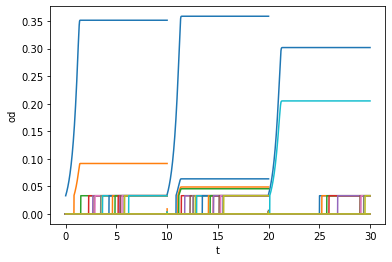

In [20]:
growthCurves(df_od)

### Fitness Relativo 

In [21]:
def get_RelFitness(bac):
    T = 1.0
    b0= 0.333
    relFitness = []
    for i,b in enumerate(bac):
        subset_bac = [bac[0], b]
        sol = solve_ivp(batch, [0,T], [1, b0/2, b0/2], args = [subset_bac], dense_output=True)
        #rel_fit = (1/T)*np.log(x[-1,2]/x[-1,1])
        rel_fit = (1/T)*np.log(sol.y[2,-1]/sol.y[1,-1])
        relFitness.append(rel_fit)
    return relFitness

In [22]:
bacteria = reconstruct_bac_list(df_ps)
rel_fit = get_RelFitness(bacteria)
df_relf = df_od.copy()

In [23]:
def relativeFitnessClones(df_od, df_relf, rel_fit):
    od_xs = df_od.columns[1:]
    for i,x in enumerate(od_xs):
        df_relf[x][df_relf[x]!=0] = rel_fit[i]
        #df_relf.loc[i,1:] = np.nan
        plt.scatter(df_relf['t'], df_relf[x], s=10)
        plt.xlabel('Time')
        plt.ylabel('Fitness Gain')
        #print(i,x)

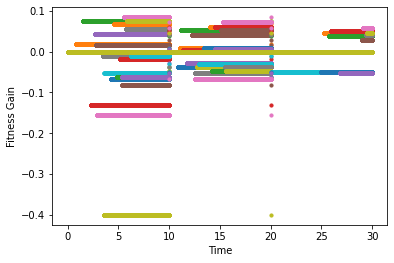

In [24]:
relativeFitnessClones(df_od, df_relf, rel_fit)

### Fitness Relativo Maximo

In [25]:
def plotRelFitnessMax(df_relf):
    fit_max =  pd.concat([df_relf['t'], df_relf.iloc[:,1:].max(axis=1)], axis=1, keys=['t', 'fit_max'])
    plt.scatter(fit_max['t'], fit_max['fit_max'],s=10)
    plt.xlabel('Time')
    plt.ylabel('Fitness Gain (Max)')

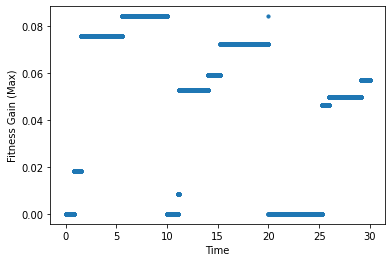

In [26]:
plotRelFitnessMax(df_relf)

### Fitness Relativo promedio

In [27]:
def plotRelFitnessMean(df_relf, df_od):
    od_times_fitness = df_od.mul(df_relf)
    sum_od_t_fitness = od_times_fitness.iloc[:,1:].sum(axis=1)
    dens = df_od.iloc[:,1:].sum(axis=1)
    avg_rel_fit = sum_od_t_fitness.mul(1/dens)
    relFitMean =  pd.concat([df_relf['t'],avg_rel_fit], axis=1, keys=['t', 'fit_mean'])
    plt.plot(relFitMean['t'], relFitMean['fit_mean'])
    plt.xlabel('Time')
    plt.ylabel('Fitness gain (Weighted average)')
    plt.savefig('Weighted_Average_Relative_Fitness_Gain.png')
    plt.show()  

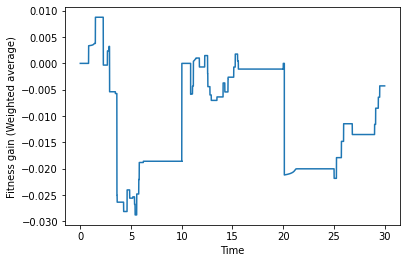

In [28]:
plotRelFitnessMean(df_relf, df_od)

### Arboles
Como se tiene registro de las relaciones parentales de cada cepa, es posible dibujar un grafo que represente la filogenia obtenida durante las simulaciones

In [29]:
def plotTree(df_ps):
    nodes = []
    for idx, mom in enumerate(df_ps['mother']):
        nodes.append((df_ps['id'][idx],mom))
        
    tree = nx.Graph(nodes)
    pos = graphviz_layout(tree, prog='twopi')
    plt.figure(figsize=(8, 8))
    nx.draw(tree, pos, node_size=15, alpha=0.5, node_color="black", with_labels=False)
    plt.show()

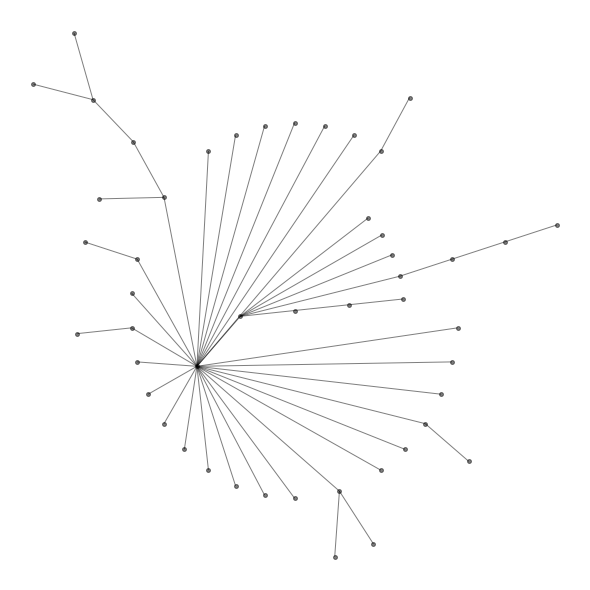

In [30]:
plotTree(df_ps)